Per il coach che correggera' questo progetto:

1. Il progetto viene mostrato seguendo la pipeline standard, dall'import alla discussione finale. Avrei potuto inserire una sezione iniziale con tutte le definizioni di funzioni, ma ho preferito lasciarle passo passo per chiarezza espositiva. Oltre alle richieste scritte nelle linee guida, ho aggiunto qualche dettaglio extra come un tentativo semplice (i.e. senza usare PyTorch) di Neural Network, sebbene non ci fossero realmente i presupposti per provarlo. Essendo il dataset piccolo, trainare un NN richiede pochi secondi e quindi non e' un grande spreco di tempo. Inoltre, ho tentato anche un RNN.

2. Ho impostato il notebook in modo estremamente didattico, con spiegazioni dettagliate di ogni passaggio (probabilmente spiegazioni ridondanti, ma meglio abbondare in questo contesto).

3. L'approccio metodologico confronta varie metriche di tutti i modelli principali di classificazione, dove gli iperparametri (ove presenti) sono selezionati tramite 5-fold cross-validation.

4. Sono consapevole che le funzioni scritte manualmente da me potrebbero essere rese molto piu' robuste (controlli sugli input, eccetera), ma ho comunque messo documentazione tramite docstring. Per tenere il progetto autoconsistente ma senza esagerare, ho usato definizioni funzionali al contesto.

5. Il notebook è stato sviluppato in modo da poter essere rieseguito integralmente dall’inizio senza errori o dipendenze esterne, ed inoltre i risultati sono riproducibile grazie all'uso dei `random_state = 0`.

6. **Non ho copiato nessun codice**, usando solo la reference ufficiale di Scikit-learn.


***Chiedo al coach una valutazione il piu' possibile severa***. Se fosse possibile, gradirei sapere la votazione, per poter tenere traccia delle mie skills in futuro.

# 0) Libraries and Imports

In [ ]:
############# Standard Imports #############

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

############# Useful Classes and Methods #############

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Normalizer, PolynomialFeatures

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, log_loss
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# 1) Dataset Exploration and Preprocessing

In questa sezione verra' esplorato il dataset.

Significato delle variabili:

- **Frutto**: Il tipo di frutto. Questa è la variabile di destinazione (target) che vogliamo prevedere.

- **Peso (g)**: Il peso del frutto in grammi. Variabile continua.

- **Diametro medio (mm)**: Il diametro medio del frutto in millimetri. Variabile continua.

- **Lunghezza media (mm)**: La lunghezza media del frutto in millimetri. Variabile continua.

- **Durezza buccia (1-10)**: La durezza della buccia del frutto su una scala da 1 a 10. Variabile continua.

- **Dolcezza (1-10)**: La dolcezza del frutto su una scala da 1 a 10. Variabile continua




In [ ]:
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv"
df = pd.read_csv(url)
target = 'Frutto'

print(f"Ci sono {df.shape[0]} campioni in questo dataset e {df.shape[1]-1} features.")
df.head()

Ci sono 500 campioni in questo dataset e 5 features.


,Frutto,Peso (g),Diametro medio (mm),Lunghezza media (mm),Durezza buccia (1-10),Dolcezza (1-10)
0,Mela,86.40,89.68,8.69,9.61,2.41
1,Mela,77.58,73.45,6.49,7.20,3.87
2,Mela,81.95,81.66,6.40,9.09,2.88
3,Mela,66.33,36.71,6.78,8.21,2.55
4,Mela,56.73,75.69,5.78,9.15,3.88


Vediamo il tipo di ogni dato: sono tutti dati numerici continui tranne il target. Inoltre non ci sono dati mancanti e quindi non e' necessario fare alcun imputing:

In [ ]:
df.info()

df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Frutto                 500 non-null    object 
 1   Peso (g)               500 non-null    float64
 2   Diametro medio (mm)    500 non-null    float64
 3   Lunghezza media (mm)   500 non-null    float64
 4   Durezza buccia (1-10)  500 non-null    float64
 5   Dolcezza (1-10)        500 non-null    float64
dtypes: float64(5), object(1)
memory usage: 23.6+ KB


,0
Frutto,0
Peso (g),0
Diametro medio (mm),0
Lunghezza media (mm),0
Durezza buccia (1-10),0
Dolcezza (1-10),0


Facciamo prima di tutto alcuni controlli sulla variabile target.

1) Verifichiamo con un semplice comando che il dataset e' perfettamente bilanciato:

In [ ]:
df[target].value_counts()

,count
Frutto,
Mela,100
Banana,100
Arancia,100
Uva,100
Kiwi,100


2. Il prossimo step da verificare e' se il target e' ben distribuito (se non lo e', in vari step dovremo impostare `shuffle = True`). Per farlo, iniziamo a fare l'encoding della variabile target. Il modo piu' semplice è usare un label encoding, salvando anche dei dizionari per ricordarci come `LabelEncoder()` ha agito. Vediamo infatti che e' necessario usare `shuffle = True`:

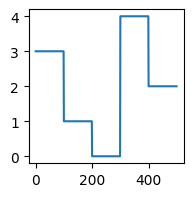

In [ ]:
le = LabelEncoder()

df[[target]] = pd.DataFrame(le.fit_transform(df[target]), columns = ["frutto"])

le.classes_ # ['Arancia' 'Banana' 'Kiwi' 'Mela' 'Uva']

num_to_labels = {i:v for i,v in enumerate(le.classes_)} # {0: 'Arancia', 1: 'Banana', 2: 'Kiwi', 3: 'Mela', 4: 'Uva'}
labels_to_num = {v:i for i,v in enumerate(le.classes_)}

plt.figure(figsize = (2,2))
plt.plot(range(0, df[[target]].shape[0]), df[[target]])
plt.show()
plt.close()

Possiamo ora fare alcuni controlli sulle features.

1) Controlliamo se c'e' correlazioni fra le variabili. Dalla heatmap sottostante vediamo che non c'e' una forte correlazione tra nessuna variabile. Quindi, per ora, manteniamo tutte le features:

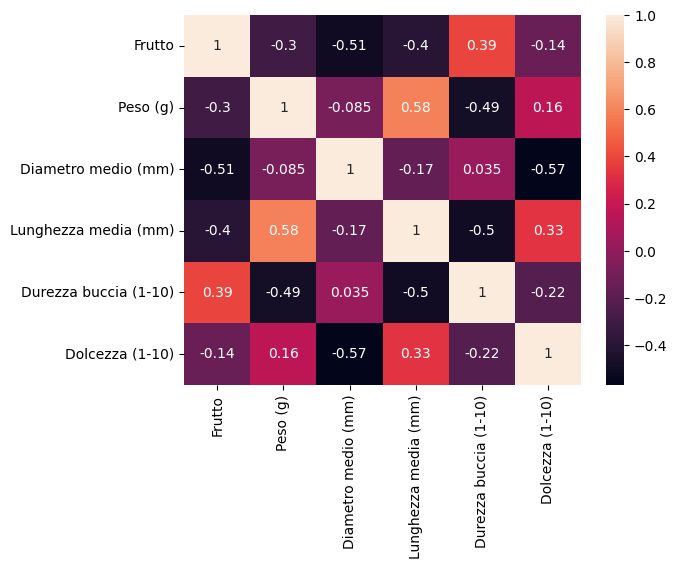

In [ ]:
corr = df.corr()
sns.heatmap(corr, annot = True)
plt.show()
plt.close()

2) L'ultimo step nella fase di preprocessing del dataset in question e' scalare i dati. Essendo tutte le colonne numeriche continue, possiamo tranquillamente applicare uno `StandarScaler()` dopo il train-test split. Per lo split, uso una test size del 30% perche' 500 dati sono pochi per usare una percentuale inferiore. Dato che le nuove features saranno a-dimensionali, cambiamo il nome alle colonne per coerenza:

In [ ]:
X = df.drop(target, axis = 1) # pandas Dataframe
y = df[[target]] # pandas Dataframe

new_names = {"Peso (g)": "peso", "Diametro medio (mm)": "diam_med",
             "Lunghezza media (mm)": "lungh_med", "Durezza buccia (1-10)": "durezza", "Dolcezza (1-10)": "dolcezza"}
X.rename(columns = new_names, inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    shuffle = True, # necessary here
                                                    stratify = y, # not really necessary
                                                    random_state = 0) # riproducibility


numerical_variables = X.columns.tolist() # this is a trick to keep the scaled X_train and X_test in the DataFrame format

ss = StandardScaler()

X_train[numerical_variables] = ss.fit_transform(X_train[numerical_variables]) # pandas Dataframe
X_test[numerical_variables] = ss.transform(X_test[numerical_variables]) # pandas Dataframe

# 2) Fit and Evaluate Functions

Prima di sviluppare un qualunque algoritmo di classificazione, e' bene avere un modello baseline a cui fare riferimento, quindi inizieremo da un modello di regressione logistica standard.

Prima ancora, ci creiamo una funzione per fittare e valutare i nostri modelli, ed un'altra funzione per visualizzare le confusion matrices:

In [ ]:
def plot_confusion_matrix(cm_train, cm_test, size = (10,4)):

  """
  Input: confusion matrices fron train and test coming from the method confusion_matrix().
  """

  # if isinstance(y_train, pd.DataFrame): y_train = y_train.values
  # if isinstance(y_test, pd.DataFrame): y_test = y_test.values
  # if isinstance(yhat_train, pd.DataFrame): yhat_train = yhat_train.values
  # if isinstance(yhat_test, pd.DataFrame): yhat_test = yhat_test.values

  # cm_train = confusion_matrix(y_train, yhat_train)
  # cm_test = confusion_matrix(y_test, yhat_test)

  df_cm_train = pd.DataFrame(cm_train)
  df_cm_test = pd.DataFrame(cm_test)

  fig, axes = plt.subplots(1,2,figsize = size)
  sns.heatmap(df_cm_train, cmap = "Blues", annot = True, annot_kws = {'size': 13}, ax = axes[0])
  sns.heatmap(df_cm_test, cmap = "Reds", annot = True, annot_kws = {'size': 13}, ax = axes[1])

  axes[0].set_title(f"Confusion Matrix - Train set")
  axes[0].set_xlabel("Predicted Label")
  axes[0].set_ylabel("True Label")

  axes[1].set_title(f"Confusion Matrix - Validation/Test set")
  axes[1].set_xlabel("Predicted Label")
  axes[1].set_ylabel("True Label")

  plt.show()
  plt.close()

def fit_evaluate(model, X_train, X_test, y_train, y_test, verbose = False):

  """
  Inputs: a model of sklearn that support .fit(), .predict_proba() and .predict(); four tensors that can be Numpy arrays or Pandas DataFrames.
  verbose: if True, the function prints a summary of the standard metrics of a classification problem, both for the train and validation/test set.
  return: model, predictions, metrics, metrics_df, confusion_matrices
  """

  if isinstance(X_train, pd.DataFrame): X_train = X_train.values
  if isinstance(X_test, pd.DataFrame): X_test = X_test.values
  if isinstance(y_train, pd.DataFrame): y_train = y_train.values
  if isinstance(y_test, pd.DataFrame): y_test = y_test.values

  model.fit(X_train, y_train.squeeze())

  yproba_train = model.predict_proba(X_train) # proabilities predictions for the training set
  yhat_train = model.predict(X_train) # predictions for the training set
  yproba_test = model.predict_proba(X_test)
  yhat_test = model.predict(X_test)

  metrics = ["Accuracy", "Log-loss", "F1-score", "Precision", "Recall"]
  split = ["Train", "Validation/Test"]

  # train metrics

  accuracy_train = accuracy_score(y_train, yhat_train)
  logloss_train = log_loss(y_train, yproba_train)
  f1_train = f1_score(y_train, yhat_train, average = 'macro') # our dataset is balanced; thus using 'macro'
  precision_train = precision_score(y_train, yhat_train, average = 'macro')
  recall_train = recall_score(y_train, yhat_train, average = 'macro')

  # test metrics

  accuracy_test = accuracy_score(y_test, yhat_test)
  logloss_test = log_loss(y_test, yproba_test)
  f1_test = f1_score(y_test, yhat_test, average = 'macro')
  precision_test = precision_score(y_test, yhat_test, average = 'macro')
  recall_test = recall_score(y_test, yhat_test, average = 'macro')

  # visualization

  metrics_df = pd.DataFrame([[accuracy_train, logloss_train, f1_train, precision_train, recall_train],
                            [accuracy_test, logloss_test, f1_test, precision_test, recall_test]], columns = metrics, index = split)

  cm_train = confusion_matrix(y_train, yhat_train)
  cm_test = confusion_matrix(y_test, yhat_test)


  if verbose:
    display(metrics_df)
    plot_confusion_matrix(cm_train, cm_test, size = (10,4))

  # return objects

  predictions = [yproba_train, yhat_train, yproba_test, yhat_test]
  metrics = [accuracy_train, logloss_train, f1_train, accuracy_test, logloss_test, f1_test]
  confusion_matrices = [cm_train, cm_test]

  return model, predictions, metrics, metrics_df, confusion_matrices

# 3) Baseline Model: Logistic Regression (accuracy 0.931 and 0.927)

,Accuracy,Log-loss,F1-score,Precision,Recall
Train,0.931429,0.190844,0.931390,0.931597,0.931429
Validation/Test,0.926667,0.187659,0.926845,0.930106,0.926667


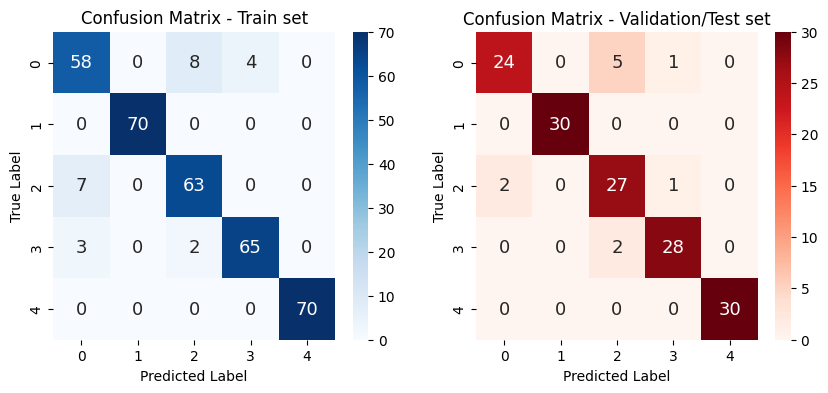

In [ ]:
lr = LogisticRegression() # for multiclass classification, in this version, 'multi_class = "multinomial"' is not needed

trained_lr, predictions_lr, metrics_lr, metrics_df_lr, confusion_matrices_lr = fit_evaluate(lr, X_train, X_test,
                                                                                            y_train, y_test, verbose = True)

I risultati sono gia' di per se soddisfacenti e, sebbene le metriche siano meno buone sul test set, la differenza con quelle del train set suggerisce che non ci sia overfitting. Vediamo anche che la classi piu' afflitte da errori sono 0-2, sia in termini di falsi negativi che di falsi positivi.

# 4) Grid Search and K-Fold Cross-Validation Functions

Possiamo ora passare al modello KNN. Il modello KNN ha due iperparametri: $K$ (numero di primi vicini da considerare per la classificazione) e $p \ge 1$ (tipo di distanza da usare). Le possibilita', per due vettori $D$-dimensionali $\vec{x}$ e $\vec{y}$  sono:

$$
d_p(\vec{x}, \vec{y}) = \biggl[\sum_{i=1}^{D} |x_i -y_i|^p\biggr]^{\frac{1}{p}}\,, \quad p\ge 1\,.
$$

Segue che questi iperparametri vanno tunati. Possiamo, per esempio, usare K-fold cross validation combinato con ricerca grid search. In questa sezione definiamo delle apposite funzioni, pensate per lavorare insieme (ed insieme al metodo `fit_evaluate()` definito precedentemente).

In [ ]:
def my_crossval(method, model, X_train, y_train, numerical_variables, verbose = True):

  """
  Input: 'method' can be an object KFold() or also LeaveOneOut(); X_train and y_train are Pandas DataFrames
  """

  accuracy_train_cv = []
  logloss_train_cv = []
  accuracy_test_cv = []
  logloss_test_cv = []

  for train_indices, test_indices in method.split(X_train):

    X_train_cv, X_test_cv = X_train.iloc[train_indices].copy(), X_train.iloc[test_indices].copy()
    y_train_cv, y_test_cv = y_train.iloc[train_indices].copy(), y_train.iloc[test_indices].copy()

    ss = StandardScaler()
    X_train_cv[numerical_variables] = ss.fit_transform(X_train_cv[numerical_variables])
    X_test_cv[numerical_variables] = ss.transform(X_test_cv[numerical_variables])

    _, _, metrics_model, _, _ = fit_evaluate(model, X_train_cv, X_test_cv, y_train_cv, y_test_cv, verbose = False)

    accuracy_train = round(metrics_model[0], 3)
    logloss_train = round(metrics_model[1], 3)
    accuracy_test = round(metrics_model[3], 3)
    logloss_test = round(metrics_model[4], 3)

    accuracy_train_cv.append(accuracy_train)
    logloss_train_cv.append(logloss_train)
    accuracy_test_cv.append(accuracy_test)
    logloss_test_cv.append(logloss_test)

  if verbose:

    print(f"\nAccuracies train: {accuracy_train_cv}; Mean accuracy: {np.mean(accuracy_train_cv).item():.3f}")
    print(f"Log-loss train: {logloss_train_cv}; Mean log-loss: {np.mean(logloss_train_cv).item():.3f}")

    print(f"\nAccuracies test: {accuracy_test_cv}; Mean accuracy: {np.mean(accuracy_test_cv).item():.3f}")
    print(f"Log-loss test: {logloss_test_cv}; Mean log-loss: {np.mean(logloss_test_cv).item():.3f}")

  return accuracy_train_cv, logloss_train_cv, accuracy_test_cv, logloss_test_cv

# usage example with a simple logistic regression model

kf = KFold (n_splits = 5, shuffle = True, random_state = 0)
model = LogisticRegression()
_, _, _, _ = my_crossval(kf, model, X_train, y_train, numerical_variables)


Accuracies train: [0.936, 0.946, 0.936, 0.932, 0.914]; Mean accuracy: 0.933
Log-loss train: [0.184, 0.187, 0.187, 0.204, 0.205]; Mean log-loss: 0.193

Accuracies test: [0.9, 0.9, 0.9, 0.929, 0.971]; Mean accuracy: 0.920
Log-loss test: [0.276, 0.235, 0.239, 0.183, 0.167]; Mean log-loss: 0.220


In [ ]:
def grid_search_KNN(method, params, verbose = True):

  """
  Input: method is KFold() or LeaveOneOut(); params is a dict with two entries: the first contains n_neighbors and the second p
  return: four dictionaries for successive analysis
  """

  mean_accuracies_train = {}
  mean_logloss_train = {}
  mean_accuracies_test = {}
  mean_logloss_test = {}

  print()
  for K in params["n_neighbors"]:
    for p in params["p"]:

      values_string = f"K = {K}, p = {p}"

      if verbose: print(f"\t\t\tUsing ({values_string})")

      KNN = KNeighborsClassifier(n_neighbors = K, p = p)
      accuracy_train_cv, logloss_train_cv, accuracy_test_cv, logloss_test_cv = my_crossval(method, KNN, X_train, y_train, numerical_variables, verbose)

      mean_accuracies_train[values_string] = np.round(np.mean(accuracy_train_cv),3).item()
      mean_logloss_train[values_string] = np.round(np.mean(logloss_train_cv),3).item()
      mean_accuracies_test[values_string] = np.round(np.mean(accuracy_test_cv),3).item()
      mean_logloss_test[values_string] = np.round(np.mean(logloss_test_cv),3).item()

      if verbose: print("\n","-"*160,"\n")

  return mean_accuracies_train, mean_logloss_train, mean_accuracies_test, mean_logloss_test

# 5) KNN Classifier (accuracy 0.934 and 0.933)

In [ ]:
kf = KFold (n_splits = 5, shuffle = True, random_state = 0)
params_grid = {"n_neighbors" : [2, 3, 4, 5, 7, 10, 12, 15, 20], "p": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

mean_accuracies_train, _, mean_accuracies_test, _ = grid_search_KNN(method = kf , params = params_grid, verbose = True)


			Using (K = 2, p = 1)

Accuracies train: [0.943, 0.957, 0.957, 0.939, 0.961]; Mean accuracy: 0.951
Log-loss train: [0.074, 0.064, 0.062, 0.074, 0.062]; Mean log-loss: 0.067

Accuracies test: [0.829, 0.9, 0.843, 0.9, 0.9]; Mean accuracy: 0.874
Log-loss test: [2.654, 1.119, 3.664, 1.119, 2.109]; Mean log-loss: 2.133

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

			Using (K = 2, p = 2)

Accuracies train: [0.939, 0.946, 0.95, 0.943, 0.954]; Mean accuracy: 0.946
Log-loss train: [0.074, 0.072, 0.074, 0.077, 0.072]; Mean log-loss: 0.074

Accuracies test: [0.829, 0.929, 0.843, 0.886, 0.929]; Mean accuracy: 0.883
Log-loss test: [3.159, 1.614, 2.654, 1.139, 1.089]; Mean log-loss: 1.931

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

			Using (K = 2, p = 3)

Acc

Dato che la griglia e' piuttosto grande, utilizziamo i dizionari ritornati dalla funzione `grid_search_KNN`. Scelgo di monitorare l'accuracy media, perche' e' una metrica della bonta' media del modello. In altri contesti, potrei voler controllare altre metriche: se per esempio fossi interessato a classificare al meglio un frutto piuttosto che un altro per ragioni di marketing, potrei controllare l'accuracy o la precision relativa a quella classe in particolare. Non avendo specifiche particolari, usiamo la accuracy media:

Best mean validation accuracy with cv is 0.929 obtained for K = 12, p = 9.
Best mean train accuracy with cv is 0.955 obtained for K = 3, p = 7
For the best parameters in the validation K = 12, p = 9, the mean train accuracy is 0.93


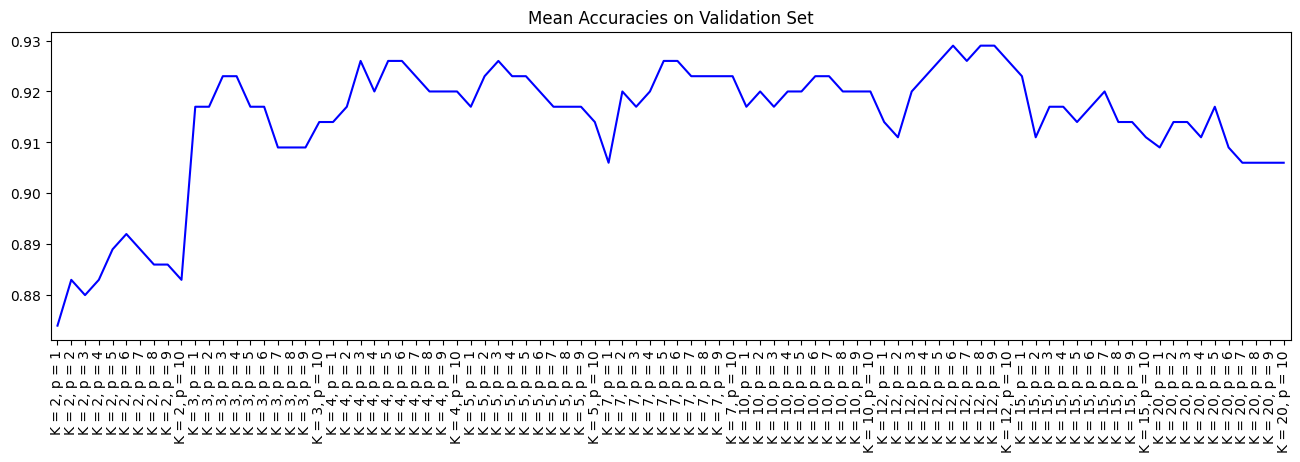

In [ ]:
# accuracy analysis

highest_value_accuracy_train = np.max(list(mean_accuracies_train.values()))
highest_value_accuracy_validation = np.max(list(mean_accuracies_test.values()))

for k,v in mean_accuracies_train.items():
  if v == highest_value_accuracy_train:
    best_params_train = k

for k,v in mean_accuracies_test.items():
  if v == highest_value_accuracy_validation:
    best_params_validation = k

print(f"Best mean validation accuracy with cv is {highest_value_accuracy_validation} obtained for {best_params_validation}.")
print(f"Best mean train accuracy with cv is {highest_value_accuracy_train} obtained for {best_params_train}")
print(f"For the best parameters in the validation {best_params_validation}, the mean train accuracy is {mean_accuracies_train[best_params_validation]}")

plt.figure(figsize = (16,4))
plt.plot(list(mean_accuracies_test.keys()), list(mean_accuracies_test.values()), c = 'blue')
plt.title("Mean Accuracies on Validation Set")
plt.xticks(rotation = 90)
plt.xlim(-0.5, len(mean_accuracies_test) - 0.5)
plt.show()
plt.close()

# logloss analysis

# highest_value_logloss_train = np.min(list(mean_logloss_train.values()))
# highest_value_logloss_validation = np.min(list(mean_logloss_test.values()))

# for k,v in mean_logloss_train.items():
#  if v == highest_value_logloss_train:
#    best_params_train = k

# for k,v in mean_logloss_test.items():
#  if v == highest_value_logloss_validation:
#    best_params_validation = k

# print(f"\nBest mean validation accuracy with cv is {highest_value_logloss_validation} obtained for {best_params_validation}.")

# print(f"Best mean train accuracy with cv is {highest_value_logloss_train} obtained for {best_params_train}")

# print(f"For the best parameters in the validation {best_params_validation}, the mean train accuracy is {mean_logloss_train[best_params_validation]}")



Per i valori $K = 12$ e $p = 9$, che danno i migliori risultati medi di cross validation sui validation set, si ha che le accuracy medie sono comparabili e l'overfitting e' trascurabile. Usiamo questi valori per ri-allenare il modello su tutto il training-set:

,Accuracy,Log-loss,F1-score,Precision,Recall
Train,0.934286,0.171383,0.934523,0.935228,0.934286
Validation/Test,0.933333,0.174005,0.933044,0.933512,0.933333


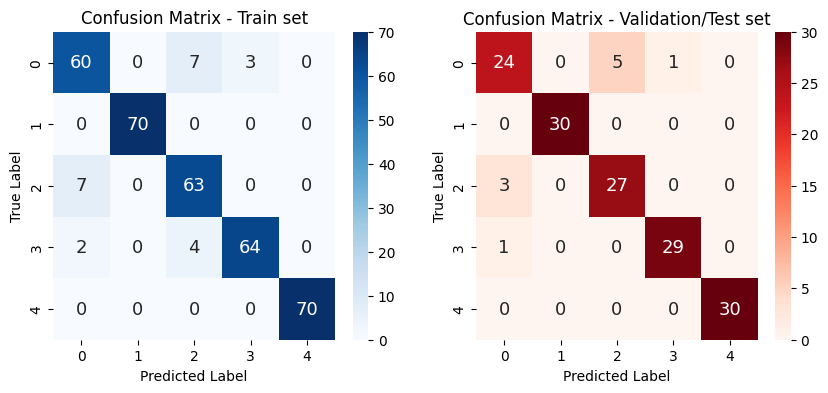

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 12, p = 9)

trained_knn, predictions_knn, metrics_knn, metrics_df_knn, confusion_matrices_knn = fit_evaluate(knn, X_train, X_test,
                                                                                            y_train, y_test, verbose = True)

# 6) RNN Classifier (accuracy 0.924 and 0.92)

Avendo definito delle funzioni che fanno tutto in automatico, non costa molto provare ad addestrare anche un RNN:

In [ ]:
def grid_search_RNN(method, params, verbose = True):

  """
  Input: method is KFold() or LeaveOneOut(); params is a dict with two entries: the first contains radius and the second p
  return: four dictionaries for successive analysis
  """

  mean_accuracies_train = {}
  mean_logloss_train = {}
  mean_accuracies_test = {}
  mean_logloss_test = {}

  print()
  for R in params["radius"]:
    for p in params["p"]:

      values_string = f"R = {R}, p = {p}"

      if verbose: print(f"\t\t\tUsing ({values_string})")

      RNN = RadiusNeighborsClassifier(radius = R, p = p)
      accuracy_train_cv, logloss_train_cv, accuracy_test_cv, logloss_test_cv = my_crossval(method, RNN, X_train, y_train, numerical_variables, verbose)

      mean_accuracies_train[values_string] = np.round(np.mean(accuracy_train_cv),3).item()
      mean_logloss_train[values_string] = np.round(np.mean(logloss_train_cv),3).item()
      mean_accuracies_test[values_string] = np.round(np.mean(accuracy_test_cv),3).item()
      mean_logloss_test[values_string] = np.round(np.mean(logloss_test_cv),3).item()

      if verbose: print("\n","-"*160,"\n")

  return mean_accuracies_train, mean_logloss_train, mean_accuracies_test, mean_logloss_test

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category = UndefinedMetricWarning) # just to suppress some standard warnings

kf = KFold (n_splits = 5, shuffle = True, random_state = 0)
params_grid = {"radius" : [2, 3, 5, 10], "p": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

mean_accuracies_train, _, mean_accuracies_test, _ = grid_search_RNN(method = kf , params = params_grid, verbose = True)


			Using (R = 2, p = 1)

Accuracies train: [0.939, 0.929, 0.939, 0.925, 0.921]; Mean accuracy: 0.931
Log-loss train: [0.172, 0.176, 0.17, 0.193, 0.187]; Mean log-loss: 0.180

Accuracies test: [0.871, 0.9, 0.886, 0.929, 0.943]; Mean accuracy: 0.906
Log-loss test: [1.716, 0.183, 1.192, 0.156, 0.168]; Mean log-loss: 0.683

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

			Using (R = 2, p = 2)

Accuracies train: [0.921, 0.918, 0.932, 0.914, 0.904]; Mean accuracy: 0.918
Log-loss train: [0.355, 0.354, 0.351, 0.358, 0.366]; Mean log-loss: 0.357

Accuracies test: [0.886, 0.914, 0.9, 0.929, 0.929]; Mean accuracy: 0.912
Log-loss test: [0.366, 0.343, 0.372, 0.364, 0.357]; Mean log-loss: 0.360

 ---------------------------------------------------------------------------------------------------------------------------------------------------------------- 

			Using (R = 2, p = 3)

A

Best mean validation accuracy with cv is 0.92 obtained for R = 3, p = 1.
Best mean train accuracy with cv is 0.931 obtained for R = 2, p = 1
For the best parameters in the validation R = 3, p = 1, the mean train accuracy is 0.924


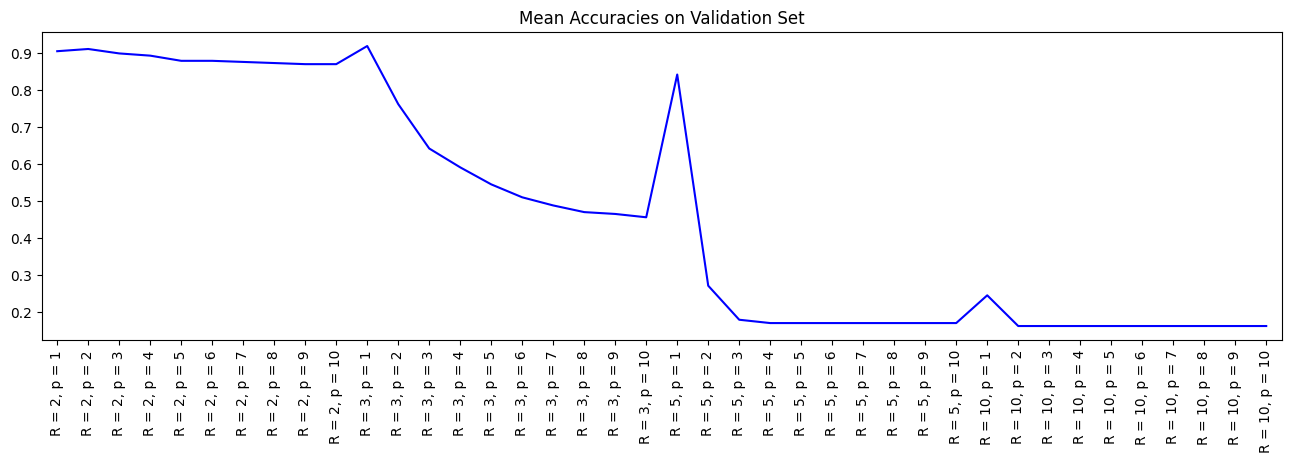

In [ ]:
# accuracy analysis

highest_value_accuracy_train = np.max(list(mean_accuracies_train.values()))
highest_value_accuracy_validation = np.max(list(mean_accuracies_test.values()))

for k,v in mean_accuracies_train.items():
  if v == highest_value_accuracy_train:
    best_params_train = k

for k,v in mean_accuracies_test.items():
  if v == highest_value_accuracy_validation:
    best_params_validation = k

print(f"Best mean validation accuracy with cv is {highest_value_accuracy_validation} obtained for {best_params_validation}.")
print(f"Best mean train accuracy with cv is {highest_value_accuracy_train} obtained for {best_params_train}")
print(f"For the best parameters in the validation {best_params_validation}, the mean train accuracy is {mean_accuracies_train[best_params_validation]}")

plt.figure(figsize = (16,4))
plt.plot(list(mean_accuracies_test.keys()), list(mean_accuracies_test.values()), c = 'blue')
plt.title("Mean Accuracies on Validation Set")
plt.xticks(rotation = 90)
plt.xlim(-0.5, len(mean_accuracies_test) - 0.5)
plt.show()
plt.close()


Il modello migliore ha $R=3$ e $p=1$:

,Accuracy,Log-loss,F1-score,Precision,Recall
Train,0.922857,0.275537,0.922256,0.924250,0.922857
Validation/Test,0.913333,0.265751,0.912357,0.915469,0.913333


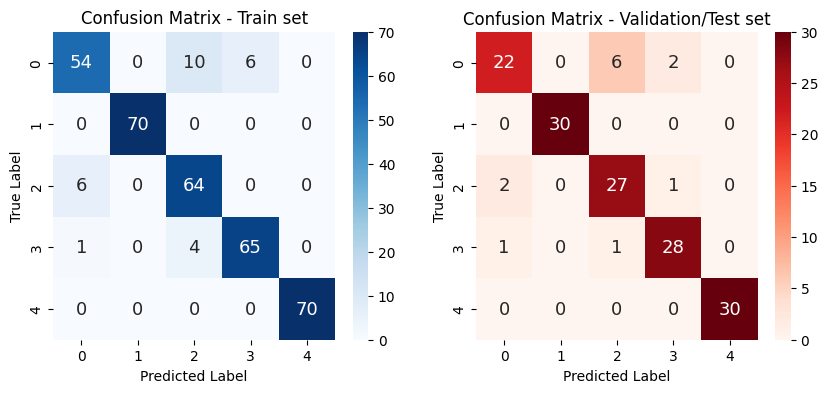

In [ ]:
rnn = RadiusNeighborsClassifier(radius = 3, p = 1)

trained_rnn, predictions_rnn, metrics_rnn, metrics_df_rnn, confusion_matrices_rnn = fit_evaluate(rnn, X_train, X_test,
                                                                                                 y_train, y_test, verbose = True)

# 7) Neural Network (accuracy 0.926 and 0.953)

Similmente, possiamo provare anche con un neural network (NN) per classificazione, quindi con relu activation nei layer interni e una softmax nell'ultimo layer per predire le probabilita' delle classi. Essendo il dataset molto piccolo per usare un NN, mi aspetto di avere subito overfitting. Per questo usero' pochi strati/neuroni e una forte regolarizzazione. Inoltre non mostro le curve standard per train e test di accuracy/loss vs epoche (con TensorFlow o PyTorch sarebbe piu' facile, ma ritengo che in questo contesto sia out-of-scope). Inoltre non ho utlizzato grid search per tunare gli iperparametri, perche' i NN non sono il focus di questo notebook. Gli iperparametri usati sono stati scelti per trial-and-error, rivelandosi una buona combinazione di complessita'/qualita'.

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


,Accuracy,Log-loss,F1-score,Precision,Recall
Train,0.925714,0.451863,0.925670,0.925661,0.925714
Validation/Test,0.953333,0.450860,0.953333,0.953333,0.953333


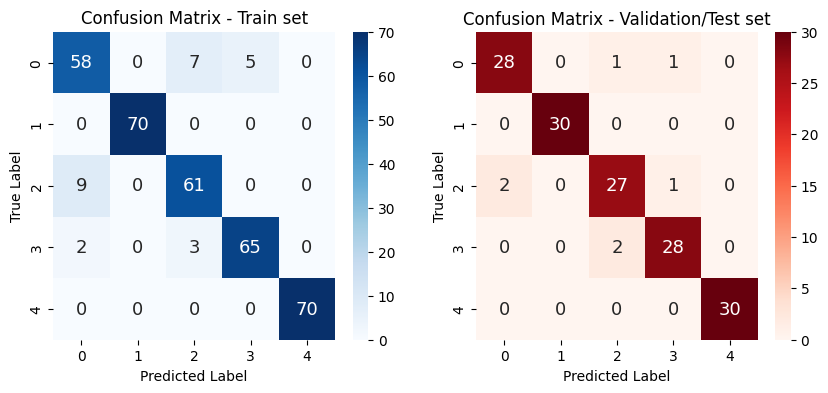

In [ ]:
LR = 0.009 # initial learning rate
EPOCHS = 30

mlp = MLPClassifier(hidden_layer_sizes = (40),
                    activation = 'relu',
                    random_state = 0,
                    alpha = 15, # strenght of L2 regularization
                    max_iter = EPOCHS,
                    learning_rate_init = LR,
                    learning_rate = 'adaptive')

y_train_mlp = y_train.copy().values.squeeze()
y_test_mlp = y_test.copy().values.squeeze()

trained_mlp, predictions_mlp, metrics_mlp, metrics_df_mlp, confusion_matrices_mlp = fit_evaluate(mlp, X_train, X_test,
                                                                                                 y_train_mlp, y_test_mlp,
                                                                                                 verbose = True)

# 8) Comparing Models and Conclusions

Possiamo ora finalmente confrontare i risultati dei vari modeli. Prima di tutto confrontiamo le principali metriche di interesse:

							LOGISTIC REGRESSION



,Accuracy,Log-loss,F1-score,Precision,Recall
Train,0.931429,0.190844,0.931390,0.931597,0.931429
Validation/Test,0.926667,0.187659,0.926845,0.930106,0.926667


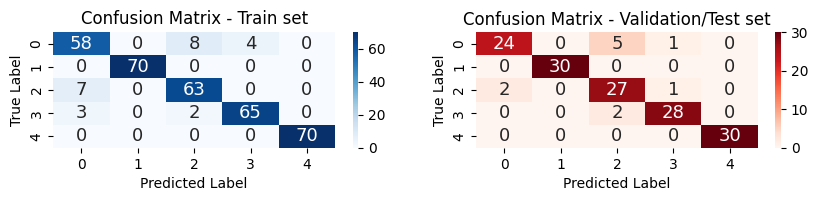


									KNN



,Accuracy,Log-loss,F1-score,Precision,Recall
Train,0.934286,0.171383,0.934523,0.935228,0.934286
Validation/Test,0.933333,0.174005,0.933044,0.933512,0.933333


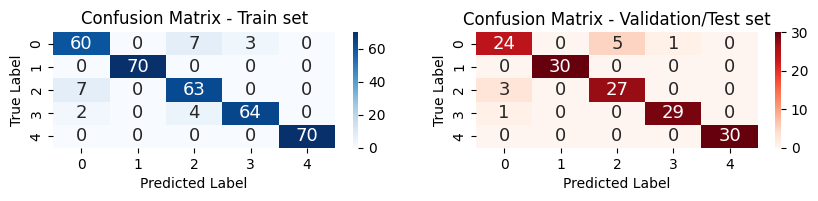


									RNN



,Accuracy,Log-loss,F1-score,Precision,Recall
Train,0.922857,0.275537,0.922256,0.924250,0.922857
Validation/Test,0.913333,0.265751,0.912357,0.915469,0.913333


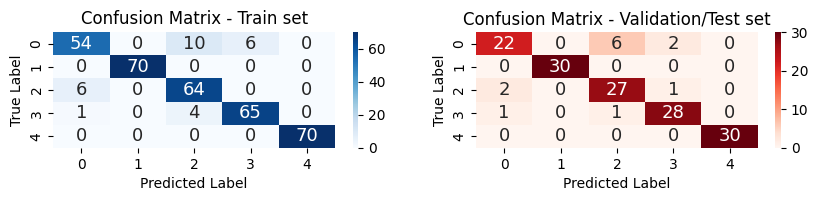


									MLP



,Accuracy,Log-loss,F1-score,Precision,Recall
Train,0.925714,0.451863,0.925670,0.925661,0.925714
Validation/Test,0.953333,0.450860,0.953333,0.953333,0.953333


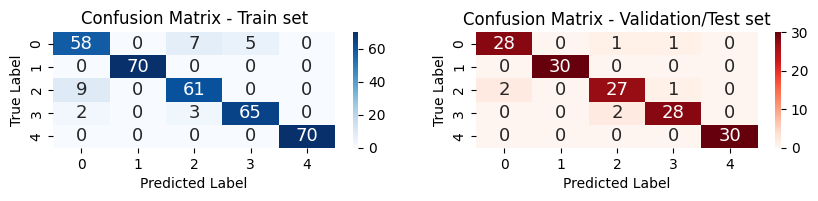

In [ ]:
models = ["LOGISTIC REGRESSION",
          "KNN", "RNN", "MLP"]

print(f"\t\t\t\t\t\t\t{models[0]}\n")

display(metrics_df_lr)
plot_confusion_matrix(confusion_matrices_lr[0], confusion_matrices_lr[1], size = (10,1.5))
print(f"\n\t\t\t\t\t\t\t\t\t{models[1]}\n")

display(metrics_df_knn)
plot_confusion_matrix(confusion_matrices_knn[0], confusion_matrices_knn[1], size = (10,1.5))

print(f"\n\t\t\t\t\t\t\t\t\t{models[2]}\n")

display(metrics_df_rnn)
plot_confusion_matrix(confusion_matrices_rnn[0], confusion_matrices_rnn[1], size = (10,1.5))

print(f"\n\t\t\t\t\t\t\t\t\t{models[3]}\n")

display(metrics_df_mlp)
plot_confusion_matrix(confusion_matrices_mlp[0], confusion_matrices_mlp[1], size = (10,1.5))

Dal confronto, NN si comporta meglio sul test set. Vediamolo anche graficamente:

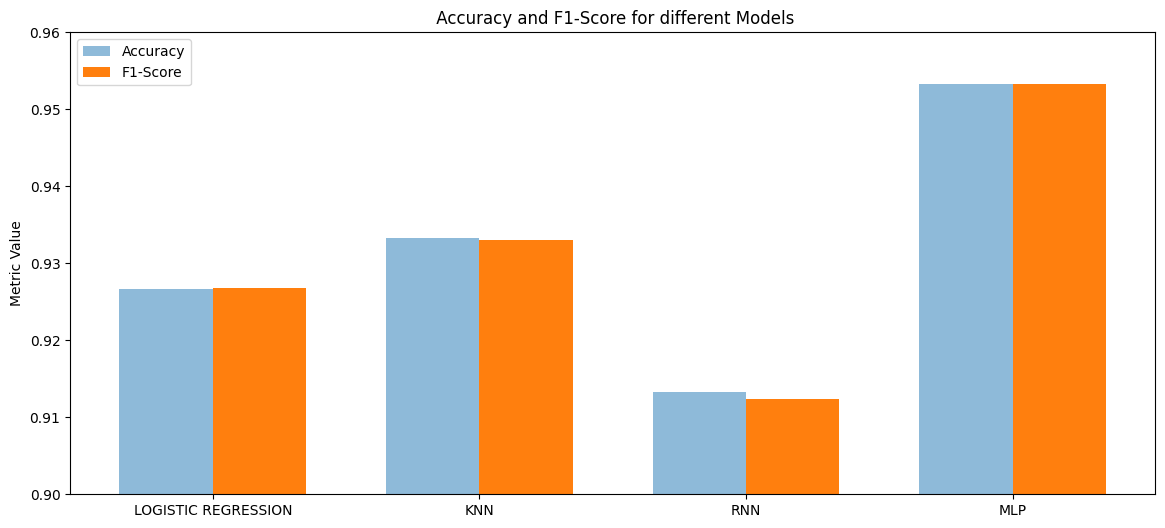

In [ ]:
accuracies = [metrics_lr[3], metrics_knn[3], metrics_rnn[3], metrics_mlp[3]]
f1scores = [metrics_lr[5], metrics_knn[5], metrics_rnn[5], metrics_mlp[5]]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize = (14, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label = 'Accuracy', alpha = 0.5)
rects2 = ax.bar(x + width/2, f1scores, width, label = 'F1-Score')

ax.set_ylabel('Metric Value')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_title(' Accuracy and F1-Score for different Models')
ax.set_ylim([0.9, 0.96])
ax.legend()

plt.show()
plt.close()

Come avevamo gia' visto dal confronto di tutte le metriche sopra, i valori di accuracy e f1-score sono migliori per il neural network. Tutti i modelli hanno problemi sulle classi 0, 2 e 3, sia come falsi positivi che come falsi negativi. In un contesto reale, suggerirei di collezionare piu' dati su queste classi per poter migliorare la qualita' del modello.

In conclusione, in questo notebook abbiamo affrontato un problema reale di classificazione multiclasse per distinguere quattro tipi di frutta, usando 5 caratteristiche numeriche continue. I risultati sono buoni per tutti i modelli, ma migliori per il neural network. Tuttavia, non avendo svolto una approfondita analisi degli iperparametri per il NN, a questo stage, ritengo sia piu' prudente (cioe' robusto) utilizzare il KNN, che spicca fra gli altri modelli provati:

In [ ]:
new_data = {'Peso (g)': [30.5, 40], 'Diametro medio (mm)': [60.4, 58.2] , 'Lunghezza media (mm)': [5.2, 4.3],
            'Durezza buccia (1-10)': [6.1, 8.2], 'Dolcezza (1-10)': [9, 4]}

new_data = pd.DataFrame(new_data)

new_data.rename(columns = new_names, inplace = True)
new_data= ss.transform(new_data[numerical_variables])
predictions_df = pd.DataFrame(knn.predict(new_data), columns = ['Predictions'])

predictions_df['Predictions'].map(num_to_labels)

,Predictions
0,Arancia
1,Uva
